In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import math
import yfinance as yf
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
import nlopt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
import warnings
from arch.univariate.base import ConvergenceWarning
from collections import deque
from filterpy.kalman import KalmanFilter
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
from filterpy.kalman import ExtendedKalmanFilter



In [4]:
# per pacchetto rugarch di R

import os
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.4.1'
os.environ['PATH'] = os.environ['PATH'] + ';C:\\Program Files\\R\\R-4.4.1\\bin\\x64'
os.add_dll_directory(r"C:\Program Files\R\R-4.4.1\bin\x64")
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
#utils.install_packages('rugarch')


In [5]:
# Scarica i dati del VIX da Yahoo Finance
VIX = yf.download('^VIX', start='2005-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

VIX["rendimenti logaritmici"] = np.log(VIX['Close'] / VIX['Close'].shift(1)).dropna()

vix_rendimenti_log = VIX["rendimenti logaritmici"]

# Visualizza i primi 5 risultati
VIX.tail()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,rendimenti logaritmici
Date,,,,,,,
2024-10-07,20.760000,23.030001,20.650000,22.639999,22.639999,0,0.164287
2024-10-08,22.920000,23.139999,21.139999,21.420000,21.420000,0,-0.055393
2024-10-09,21.980000,22.010000,20.709999,20.860001,20.860001,0,-0.026492
2024-10-10,20.910000,21.389999,20.639999,20.930000,20.930000,0,0.003350
2024-10-11,20.870001,21.160000,20.139999,20.459999,20.459999,0,-0.022712


In [6]:
# Scarica i dati dell'S&P 500 da Yahoo Finance
sp500 = yf.download('^GSPC', start='2005-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Calcola i rendimenti logaritmici
sp500_log_returns = sp500['Log Returns'] = np.log(sp500['Adj Close'] / sp500['Adj Close'].shift(1)).dropna()

sp500_high_log_returns = np.log(sp500['High'] / sp500['High'].shift(1)).dropna()

[*********************100%%**********************]  1 of 1 completed


In [7]:
print(f"sp500 initial data: {sp500.index[0]}")
print(f"VIX initial data: {VIX.index[0]}")

print(f"sp500 len data: {len(sp500)}")
print(f"VIX len data: {len(VIX)}")

sp500 initial data: 2005-01-03 00:00:00
VIX initial data: 2005-01-03 00:00:00
sp500 len data: 4978
VIX len data: 4978


In [8]:
def confronta_date(sp500_log_returns, VIX):
   
    # Ottieni gli indici di entrambe le serie come insiemi di date
    date_sp500 = set(sp500_log_returns.index)
    date_vix = set(VIX.index)
    
    # Trova le date presenti in sp500_log_returns ma non in VIX
    date_solo_sp500 = date_sp500 - date_vix
    for data in date_solo_sp500:
        print(f"La data {data} è presente in sp500_log_returns ma non in VIX.")
    
    # Trova le date presenti in VIX ma non in sp500_log_returns
    date_solo_vix = date_vix - date_sp500
    for data in date_solo_vix:
        print(f"La data {data} è presente in VIX ma non in sp500_log_returns.")

confronta_date(sp500_log_returns, VIX)


La data 2005-01-03 00:00:00 è presente in VIX ma non in sp500_log_returns.


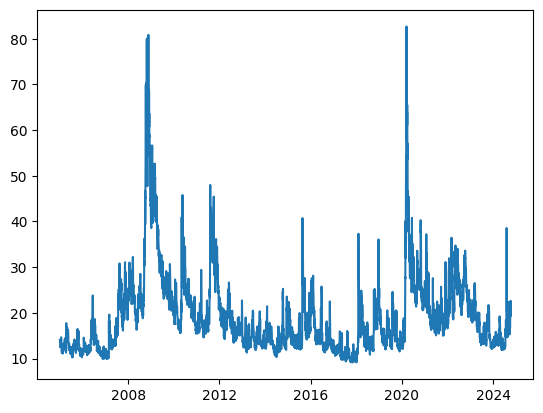

In [9]:
vix_close_price = VIX['Close'].copy()

plt.plot(vix_close_price)


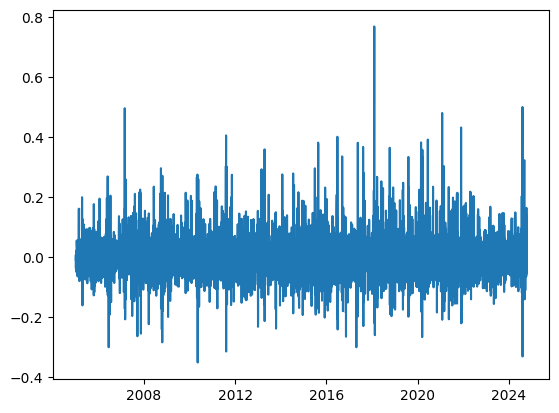

In [10]:
plt.plot(vix_rendimenti_log)

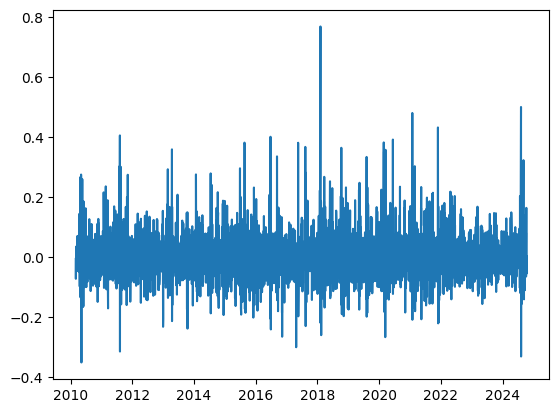

In [11]:
plt.plot(vix_rendimenti_log[1300:])


### <span style="background-color: yellow; color: black; font-weight: bold;"> VIX forecasting and variance risk premium</span>

In [12]:
import statsmodels.api as sm



def fit_garch_model(returns, horizon):

    model = arch_model(returns, vol='Garch', p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")
    params = model_fit.params
    v_t = model_fit.conditional_volatility ** 2
    forecast = model_fit.forecast(horizon=horizon)
    v_t_forecast = forecast.variance.iloc[-1, horizon-1]
    
    return v_t, v_t_forecast, params



In [13]:
def fit_garch_model_2(returns, rescaling_factor=1000, horizon=2):

    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    model = arch_model(returns_clean*rescaling_factor, vol='Garch', p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")

    params = (model_fit.params[0], model_fit.params[1]/rescaling_factor**2, model_fit.params[2], model_fit.params[3])
    v_t = (model_fit.conditional_volatility ** 2) / rescaling_factor**2
    forecast = model_fit.forecast(horizon=horizon) 
    v_t_forecast =forecast.variance.iloc[-1, horizon-1] / rescaling_factor**2
    
    return v_t, v_t_forecast, params, model_fit



In [14]:
def fit_garch_m_model(returns):

    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    rescaling_factor = 1000

    #prima applico il modello a media zero per ottenere la varianza condizionale che verra messa in in input al successivo modello per creare il modello garch-m
    model = arch_model(returns_clean*rescaling_factor, vol='Garch', p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")
    v_t_temp = (model_fit.conditional_volatility ** 2) / rescaling_factor**2
    forecast_temp = model_fit.forecast(horizon=2)
    v_t_forecast_1 = forecast_temp.variance.iloc[-1, 0] / rescaling_factor**2
    v_t_forecast_2 = forecast_temp.variance.iloc[-1, 1] / rescaling_factor**2
    v_t_temp = v_t_temp.shift(-1).fillna(v_t_forecast_1)

    model = arch_model(returns_clean*rescaling_factor, vol='Garch', mean='ARX', x=v_t_temp**(1/2), p=1, q=1, rescale=False)
    model_fit = model.fit(disp="off")

    params = (model_fit.params[0], model_fit.params[1]/rescaling_factor**2, model_fit.params[2], model_fit.params[3])
    v_t = (model_fit.conditional_volatility ** 2) / rescaling_factor**2

    # Previsione: è necessario passare ancora i valori della varianza condizionale, essendo h=2 nel forecast serviranno le previsioni h=1 e h=2
    last_v_t = v_t.iloc[-1]
    exog_forecast = np.array([v_t_forecast_1, v_t_forecast_2]) 

    # Generazione della previsione
    forecast = model_fit.forecast(horizon=2, x=exog_forecast)
    v_t_forecast = forecast.variance.iloc[-1, 1] / rescaling_factor**2
    
    return v_t, v_t_forecast, params




In [15]:
# Attivare la conversione automatica tra pandas e R
pandas2ri.activate()

# Importare il pacchetto rugarch di R
rugarch = importr('rugarch')

# Funzione di accesso agli slot
def get_rslot(obj, slot_name):
    return obj.do_slot(slot_name)

# Funzione modificata
def fit_aparch_model_rugarch(returns):
    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    rescaling_factor = 1000
    returns_scaled = returns_clean * rescaling_factor

    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_returns = robjects.conversion.py2rpy(returns_scaled)

    spec = rugarch.ugarchspec(variance_model=robjects.ListVector({
                                "model": "apARCH",
                                "garchOrder": robjects.IntVector([1, 1])
                             }),
                             mean_model=robjects.ListVector({
                                "armaOrder": robjects.IntVector([0, 0]),
                                "include_mean": True
                             }),
                             distribution_model="std")
    fit = rugarch.ugarchfit(spec=spec, data=r_returns)

    # Accedi ai parametri usando do_slot
    fit_slot = get_rslot(fit, 'fit')
    coef = fit_slot.rx2('coef')
    omega = coef[0] / rescaling_factor**2
    alpha = coef[1] / rescaling_factor**2
    params = {
        "mu": coef[2],
        "omega": omega,
        "alpha": alpha,
        "beta": coef[3],
        "gamma": coef[4],
        "delta": coef[5]
    }

    sigma_t = fit_slot.rx2('sigma')
    v_t = np.array(sigma_t)**2 / rescaling_factor**2

    # Previsione a 2 passi
    forecast = rugarch.ugarchforecast(fit, n_ahead=2)
    forecast_slot = get_rslot(forecast, 'forecast')
    sigmaFor = forecast_slot.rx2('sigmaFor')
    v_t_forecast = np.array(sigmaFor)[1]**2 / rescaling_factor**2

    return v_t, v_t_forecast, params


In [16]:
# Attivare la conversione automatica tra pandas e R
pandas2ri.activate()

# Importare il pacchetto rugarch di R
rugarch = importr('rugarch')

# Funzione di accesso agli slot
def get_rslot(obj, slot_name):
    return obj.do_slot(slot_name)

# Funzione per adattare un modello EGARCH utilizzando rugarch
def fit_egarch_model_rugarch(returns):
    
    # Pulizia dei dati
    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    # Riscalatura dei rendimenti
    rescaling_factor = 1000
    returns_scaled = returns_clean * rescaling_factor

    # Conversione dei dati per R
    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_returns = robjects.conversion.py2rpy(returns_scaled)

    # Specificazione del modello EGARCH
    spec = rugarch.ugarchspec(variance_model=robjects.ListVector({
                                "model": "eGARCH",  # Modello EGARCH
                                "garchOrder": robjects.IntVector([1, 1])
                             }),
                             mean_model=robjects.ListVector({
                                "armaOrder": robjects.IntVector([0, 0]),
                                "include_mean": True
                             }),
                             distribution_model="std")
    
    # Fitting del modello EGARCH
    fit = rugarch.ugarchfit(spec=spec, data=r_returns, solver="hybrid")

    fit_slot = get_rslot(fit, 'fit')

    # Verifica se fit_slot è NULL
    if fit_slot is None:
        raise ValueError("Il fitting del modello ha fallito, controlla i dati o la specifica del modello.")
    
    coef = fit_slot.rx2('coef')

    # Verifica se coef è NULL
    if coef is None:
        raise ValueError("Il modello non ha prodotto coefficienti, verifica i dati e la specifica.")

    # Estrazione dei parametri EGARCH
    omega = coef[0] / rescaling_factor**2
    alpha = coef[1] / rescaling_factor**2
    gamma = coef[2]  # gamma non deve essere riscalato
    beta = coef[3]   # beta non deve essere riscalato

    params = {
        "omega": omega,
        "alpha": alpha,
        "gamma": gamma,
        "beta": beta
    }

    sigma_t = fit_slot.rx2('sigma')
    v_t = np.array(sigma_t)**2 / rescaling_factor**2

    # Previsione a 2 passi
    forecast = rugarch.ugarchforecast(fit, n_ahead=2)
    forecast_slot = get_rslot(forecast, 'forecast')
    sigmaFor = forecast_slot.rx2('sigmaFor')
    v_t_forecast = np.array(sigmaFor)[1]**2 / rescaling_factor**2

    return v_t, v_t_forecast, params


In [17]:
# Attivare la conversione automatica tra pandas e R
pandas2ri.activate()

# Importare il pacchetto rugarch di R
rugarch = importr('rugarch')

# Funzione di accesso agli slot
def get_rslot(obj, slot_name):
    return obj.do_slot(slot_name)

# Funzione per adattare il modello GJR-GARCH
def fit_gjr_garch_model_rugarch(returns):
    
    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    rescaling_factor = 1000
    returns_scaled = returns_clean * rescaling_factor

    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_returns = robjects.conversion.py2rpy(returns_scaled)

    # Specifica del modello GJR-GARCH
    spec = rugarch.ugarchspec(variance_model=robjects.ListVector({
                                "model": "gjrGARCH",
                                "garchOrder": robjects.IntVector([1, 1])
                             }),
                             mean_model=robjects.ListVector({
                                "armaOrder": robjects.IntVector([0, 0]),
                                "include_mean": True
                             }),
                             distribution_model="std")
    
    fit = rugarch.ugarchfit(spec=spec, data=r_returns)

    fit_slot = get_rslot(fit, 'fit')

    # Verifica se fit_slot è NULL
    if fit_slot is None:
        raise ValueError("Il fitting del modello ha fallito, controlla i dati o la specifica del modello.")
    
    coef = fit_slot.rx2('coef')

    # Verifica se coef è NULL
    if coef is None:
        raise ValueError("Il modello non ha prodotto coefficienti, verifica i dati e la specifica.")

    omega = coef[0] / rescaling_factor**2
    alpha = coef[1] / rescaling_factor**2
    params = {
        "mu": coef[2],
        "omega": omega,
        "alpha": alpha,
        "beta": coef[3],
        "gamma": coef[4],  # Coefficiente asimmetrico nel modello GJR-GARCH
    }

    sigma_t = fit_slot.rx2('sigma')
    v_t = np.array(sigma_t)**2 / rescaling_factor**2

    # Previsione a 2 passi
    forecast = rugarch.ugarchforecast(fit, n_ahead=2)
    forecast_slot = get_rslot(forecast, 'forecast')
    sigmaFor = forecast_slot.rx2('sigmaFor')
    v_t_forecast = np.array(sigmaFor)[1]**2 / rescaling_factor**2

    return v_t, v_t_forecast, params


In [18]:
# Attivare la conversione automatica tra pandas e R
pandas2ri.activate()

# Importare il pacchetto rugarch di R
rugarch = importr('rugarch')

# Funzione di accesso agli slot
def get_rslot(obj, slot_name):
    return obj.do_slot(slot_name)

# Funzione per adattare il modello Stochastic Volatility GARCH (StGARCH)
def fit_stgarch_model_rugarch(returns):
    returns_clean = returns.dropna()
    returns_clean = returns_clean[np.isfinite(returns_clean)]

    rescaling_factor = 1000
    returns_scaled = returns_clean * rescaling_factor

    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_returns = robjects.conversion.py2rpy(returns_scaled)

    # Specifica del modello StGARCH
    spec = rugarch.ugarchspec(variance_model=robjects.ListVector({
                                "model": "StGARCH",
                                "garchOrder": robjects.IntVector([1, 1])
                             }),
                             mean_model=robjects.ListVector({
                                "armaOrder": robjects.IntVector([0, 0]),
                                "include_mean": True
                             }),
                             distribution_model="std")
    
    fit = rugarch.ugarchfit(spec=spec, data=r_returns)

    fit_slot = get_rslot(fit, 'fit')

    # Verifica se fit_slot è NULL
    if fit_slot is None:
        raise ValueError("Il fitting del modello ha fallito, controlla i dati o la specifica del modello.")
    
    coef = fit_slot.rx2('coef')

    # Verifica se coef è NULL
    if coef is None:
        raise ValueError("Il modello non ha prodotto coefficienti, verifica i dati e la specifica.")

    omega = coef[0] / rescaling_factor**2
    alpha = coef[1] / rescaling_factor**2
    params = {
        "mu": coef[2],
        "omega": omega,
        "alpha": alpha,
        "beta": coef[3],
        "gamma": coef[4],  # Coefficiente asimmetrico
        "rho": coef[5],    # Coefficiente per la volatilità stocastica
        "delta": coef[6]   # Coefficiente per il processo di volatilità stocastica
    }

    sigma_t = fit_slot.rx2('sigma')
    v_t = np.array(sigma_t)**2 / rescaling_factor**2

    # Previsione a 2 passi
    forecast = rugarch.ugarchforecast(fit, n_ahead=2)
    forecast_slot = get_rslot(forecast, 'forecast')
    sigmaFor = forecast_slot.rx2('sigmaFor')
    v_t_forecast = np.array(sigmaFor)[1]**2 / rescaling_factor**2

    return v_t, v_t_forecast, params


In [19]:

def objective_function_nlopt(params, grad, v_t, vix_market_real):
    alpha_star, beta_star, omega_star = params
    xi_star = alpha_star + beta_star
    V_L_star = omega_star / (1 - xi_star)
    a = (1 - xi_star ** 30) / (30 * (1 - xi_star))
    b = V_L_star * (1 - a)
    vix_model = np.sqrt(100**2 * 365 * (a * v_t + b))
    error = (vix_model - vix_market_real)**2

    if grad.size > 0:
        grad[:] = 0.0  # Non calcoliamo il gradiente

    return error

def calibrate_risk_neutral_params_nlopt(v_t, vix_market_real):
    # Parametri iniziali
    initial_params = np.array([0.05, 0.9, 1e-6])

    # Limiti dei parametri
    lower_bounds = [0, 0, 1e-6]
    upper_bounds = [1, 1, 1e6]

    # Creazione dell'ottimizzatore NLopt
    opt = nlopt.opt(nlopt.GN_ISRES, 3)
    opt.set_maxeval(10000000)

    # Impostazione dei limiti
    opt.set_lower_bounds(lower_bounds)
    opt.set_upper_bounds(upper_bounds)

    # Impostazione della funzione obiettivo
    opt.set_min_objective(lambda params, grad: objective_function_nlopt(params, grad, v_t, vix_market_real))

    # Impostazione del vincolo xi_star < 1
    def xi_constraint(params, grad):
        alpha_star, beta_star, omega_star = params
        if grad.size > 0:
            grad[0] = 1.0
            grad[1] = 1.0
            grad[2] = 0.0  # gradiente rispetto a omega_star
        return alpha_star + beta_star - 1

    opt.add_inequality_constraint(xi_constraint)

    # Impostazione delle tolleranze
    opt.set_xtol_rel(1e-7)
    opt.set_ftol_rel(1e-3)

    # Esecuzione dell'ottimizzazione
    result = opt.optimize(initial_params)
    return result



In [20]:
def objective_function(params, v_t, vix_market_real):
    
    alpha_star, beta_star, omega_star = params
    xi_star = alpha_star + beta_star
    V_L_star = omega_star / (1 - xi_star)
    a = (1 - xi_star ** 30) / (30 * (1 - xi_star))
    b = V_L_star * (1 - a)
    vix_model = np.sqrt(100**2 * 365 * (a * v_t + b))
    error = (vix_model - vix_market_real)**2

    penality = 0 

    if(alpha_star + beta_star >= 1):
        penality = 1e8

    return error + penality

def xi_constraint(params):
    alpha_star, beta_star, omega_star = params
    return alpha_star + beta_star


constraint = NonlinearConstraint(xi_constraint, 0, 1)


def calibrate_risk_neutral_params(v_t, vix_market_real):
    
    if np.isnan(v_t).any() or np.isinf(v_t).any():
        print("v_t contiene valori NaN o infiniti.")
    
    if np.isnan(vix_market_real).any() or np.isinf(vix_market_real).any():
        print("vix_market_real contiene valori NaN o infiniti.")


    initial_params = np.array([0.05, 0.9, 1e-6])
    bounds = [(0, 1), (0, 1), (1e-6, 1e6)]
    result = minimize(objective_function, initial_params, args=(v_t, vix_market_real), 
                      bounds=bounds, constraints=[constraint], method='nelder-mead')
    return result.x


In [21]:
def calculate_vix(params_star, v_t):
    alpha_star, beta_star, omega_star = params_star
    xi_star = alpha_star + beta_star
    V_L_star = omega_star / (1 - xi_star)
    a = (1 - xi_star ** 30) / (30 * (1 - xi_star))
    b = V_L_star * (1 - a)
    vix_forecast = np.sqrt(100**2 * 365 * (a * v_t + b))
    return vix_forecast


In [22]:
def absolute_percentage_error_function(vix_real, vix_forecast):

    return np.abs(vix_forecast - vix_real) / vix_real

In [23]:
def percentage_error_function(vix_real, vix_forecast):

    return (vix_forecast - vix_real) / vix_real

In [24]:
def lm_arch_test(serie):

    lm_test = het_arch(serie)

    print("Statistiche del test LM:", lm_test[0])
    print("P-value:", lm_test[1])
    print("F-statistic:", lm_test[2])
    print("F-test P-value:", lm_test[3])
    
    return lm_test

In [25]:
vix_forecast_list = []
def garch_models_cross_validation(sp500_log_returns, start_date, end_date, len_period=50):

    len_period_residual_error = 100
    percentage_absolute_error_list = []
    percentage_error_list = []  
    residual_errors = deque(maxlen=len_period_residual_error)
    

    # Inizializzazione dei parametri per l'ECM
    previous_error = 0  # Errore precedente
    alpha_ecm = 0.5  # Parametro di aggiustamento errore


    #format date: 'YYYY-MM-DD' 
    try:
        start_index = sp500_log_returns.index.get_loc(start_date)
    except Exception as e:
            print(f"La data iniziale fornita non esiste nel dataframe: {e}")
    
    try:
        end_index = sp500_log_returns.index.get_loc(end_date)
    except Exception as e:
            print(f"La data finale fornita non esiste nel dataframe: {e}")


    for i in range(start_index, end_index, 1):
        
        print(f"Iterazione: {i}")

        sp500_log_returns_garch = sp500_log_returns[i-len_period : i].dropna()
        #vix_market_real = VIX.iloc[i-2]["Close"]
        vix_market_real = VIX.iloc[i-2]["High"]

        try:
            with warnings.catch_warnings(record=True) as w:
                # Ignora tutti i warning tranne quelli che vuoi catturare
                warnings.simplefilter("always")
                
                # 1. Applicare il modello GARCH(1,1) ai rendimenti del S&P 500
                v_t, v_t_forecast, empirical_params, garch_results = fit_garch_model_2(sp500_log_returns_garch, 1000, 2)

                # Controlla se è stato emesso un ConvergenceWarning
                if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                    print(f"ConvergenceWarning durante l'iterazione {i}, saltando iterazione.")
                    continue

                # 2. Calibrare i parametri sotto la misura neutrale al rischio
                #    -> usare v_t.iloc[-1] come default e v_t[-1] quando si usano i modelli rugarch
                params_star = calibrate_risk_neutral_params_nlopt(v_t[-1], vix_market_real)

                alpha = params_star[0]
                beta = params_star[1]

                if alpha + beta >= 1:
                    print(f"Warning: alpha + beta >= 1 (alpha: {alpha}, beta: {beta}) nella iterazione {i}")
                    continue
                
                  # 3. Prevedere il VIX per la data di previsione
                vix_forecast = calculate_vix(params_star, v_t_forecast)
                
                """
                previous_error = 0 if not residual_errors else residual_errors[-1]

                # 4. Se ci sono abbastanza errori residui, applica un modello GARCH su di essi
                if len(residual_errors) > len_period_residual_error -1:
                    
                    # Modello GARCH(1,1) sull'errore residuo
                    v_t_error, v_t_forecast_error, empirical_params_error, garch_results_error = fit_garch_model_2(pd.Series(list(residual_errors)), 10, 1)
                    
                    # Aggiornare la previsione del VIX con la previsione dell'errore corretto
                    vix_forecast_corrected = vix_forecast + v_t_forecast_error * previous_error
                else:
                    # Se non ci sono abbastanza dati, usa l'errore corrente come correzione
                    vix_forecast_corrected = vix_forecast + previous_error*0.5
                """
                
                
                vix_forecast_corrected = vix_forecast + 0.5 * previous_error

                #vix_forecast_corrected = vix_forecast + 0.5 * previous_error

                # 5. Calcolare l'errore residuo
                #current_error = VIX.iloc[i]["Close"] - vix_forecast_corrected
                current_error = VIX.iloc[i]["High"] - vix_forecast_corrected

                previous_error = current_error

                # 5. Aggiungere l'errore residuo alla lista
                residual_errors.append(current_error)
                    
                # 6. Calcolare gli errori percentuali
                #ape = absolute_percentage_error_function(VIX.iloc[i]["Close"], vix_forecast_corrected)
                #pe = percentage_error_function(VIX.iloc[i]["Close"], vix_forecast_corrected)

                ape = absolute_percentage_error_function(VIX.iloc[i]["High"], vix_forecast_corrected)
                pe = percentage_error_function(VIX.iloc[i]["High"], vix_forecast_corrected)

                percentage_absolute_error_list.append((ape, sp500_log_returns.index[i]))
                percentage_error_list.append((pe, sp500_log_returns.index[i]))

                vix_forecast_list.append((vix_forecast_corrected, sp500_log_returns.index[i]))

        except Warning as w:
            print(f"Warning during iteration {i}: {w}")

        except Exception as e:
            print(f"Errore durante l'iterazione {i}: {e}")
            continue

    return  percentage_absolute_error_list, percentage_error_list   

Note:
* returns: è una serie temporale dei rendimenti giornalieri del S&P 500.
* vix_market_previous: è il valore del VIX osservato nel mercato il giorno precedente.
* Il codice utilizza la libreria arch per stimare i parametri del modello GARCH(1,1).
* La funzione minimize di scipy.optimize è usata per calibrare i parametri sotto la misura neutrale al rischio.

In [26]:
"""
def garch_models_with_kalman_cross_validation(start_date, end_date, len_period=50, window_size=50):

    percentage_absolute_error_list = []
    percentage_error_list = []  

    # Inizializza l'EKF con dimensione di stato e osservazione 1
    ekf = ExtendedKalmanFilter(dim_x=1, dim_z=1)
    ekf.x = np.array([0.1])       # Stato iniziale (varianza condizionale)
    ekf.P = np.array([[0.0001]])  # Covarianza iniziale dell'errore di stato
    ekf.Q = np.array([[0.001]])  # Covarianza del rumore di processo
    ekf.R = np.array([[0.001]])  # Covarianza del rumore di osservazione

    # Inizializza coda per mantenere i precedenti window_size residui
    residuals_queue = deque(maxlen=window_size)

    # Inizializza coda per mantenere i precedenti window_size errori di processo
    process_noise_queue = deque(maxlen=window_size)


    # Trova gli indici di inizio e fine nel dataframe
    try:
        start_index = sp500_log_returns.index.get_loc(start_date)
    except Exception as e:
        print(f"La data iniziale fornita non esiste nel dataframe: {e}")
    

    try:
        end_index = sp500_log_returns.index.get_loc(end_date)
    except Exception as e:
        print(f"La data finale fornita non esiste nel dataframe: {e}")


    # Funzione di osservazione non lineare
    def h_function(x, params):
        return np.array([[np.sqrt((params[0] * x + params[1]) * 365 * 100**2)]])
    
    # Jacobiano della funzione di osservazione rispetto allo stato
    def H_jacobian(x, params):
        a = params[0]
        b = params[1]
        C = 365 * 100**2
        result = (a * C / (2 * np.sqrt(C * (a * x + b))))
        result = 0 if (result < 0 or result="Nan") else result
        return np.array([[ result ]])   

    # Loop attraverso il periodo di tempo specificato
    for i in range(start_index, end_index, 1):
        print(f"Iterazione: {i}")

        sp500_log_returns_garch = sp500_log_returns[i-len_period : i].dropna()
        vix_market_real = VIX.iloc[i-2]["Close"]

        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always")
                
                # 1. Applicare il modello GARCH(1,1) ai rendimenti del S&P 500
                v_t, v_t_forecast, empirical_params, garch_results = fit_garch_model_2(sp500_log_returns_garch)

                if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                    print(f"ConvergenceWarning durante l'iterazione {i}, saltando iterazione.")
                    continue

                # 2. Calibrare i parametri sotto la misura neutrale al rischio
                params_star = calibrate_risk_neutral_params_nlopt(ekf.x[0], vix_market_real)
                alpha = params_star[0]
                beta = params_star[1]

                if alpha + beta >= 1:
                    print(f"Warning: alpha + beta >= 1 (alpha: {alpha}, beta: {beta}) nella iterazione {i}")
                    continue

                # Calcolo di R: mantieni solo gli ultimi x residui e calcola la varianza
                residual = calculate_vix(params_star, v_t_forecast) - vix_market_real
                residuals_queue.append(residual) 
                R = np.array([[np.var(residuals_queue)]])  
                ekf.R = R  # Aggiorna la matrice R dell'EKF

                # Calcolo di Q: mantieni solo gli ultimi x errori di processo e calcola la varianza
                if i > start_index:  # Assicurarsi che ci sia almeno una differenza
                    process_noise = v_t[-1] - v_t[-2]  
                    process_noise_queue.append(process_noise)  
                    Q = np.array([[np.var(process_noise_queue)]])  
                    ekf.Q = Q  # Aggiorna la matrice Q dell'EKF


                 # Predizione dello stato
                ekf.predict()
                
                # Aggiornamento dello stato basato sulla nuova osservazione
                ekf.update(z=vix_market_real, HJacobian=H_jacobian, Hx=h_function, args=(params_star,), hx_args=(params_star,))
                
                vix_forecast_updated = ekf.x[0]  # Ora accedi correttamente al primo elemento

                # Calcolo dell'errore percentuale
                ape = absolute_percentage_error_function(VIX.iloc[i]["Close"], vix_forecast_updated)
                pe = percentage_error_function(VIX.iloc[i]["Close"], vix_forecast_updated)

                percentage_absolute_error_list.append((ape, sp500_log_returns.index[i]))
                percentage_error_list.append((pe, sp500_log_returns.index[i]))

        except Warning as w:
            print(f"Warning during iteration {i}: {w}")
        except Exception as e:
            print(f"Errore durante l'iterazione {i}: {e}")
            continue

    return percentage_absolute_error_list, percentage_error_list
"""

'\ndef garch_models_with_kalman_cross_validation(start_date, end_date, len_period=50, window_size=50):\n\n    percentage_absolute_error_list = []\n    percentage_error_list = []  \n\n    # Inizializza l\'EKF con dimensione di stato e osservazione 1\n    ekf = ExtendedKalmanFilter(dim_x=1, dim_z=1)\n    ekf.x = np.array([0.1])       # Stato iniziale (varianza condizionale)\n    ekf.P = np.array([[0.0001]])  # Covarianza iniziale dell\'errore di stato\n    ekf.Q = np.array([[0.001]])  # Covarianza del rumore di processo\n    ekf.R = np.array([[0.001]])  # Covarianza del rumore di osservazione\n\n    # Inizializza coda per mantenere i precedenti window_size residui\n    residuals_queue = deque(maxlen=window_size)\n\n    # Inizializza coda per mantenere i precedenti window_size errori di processo\n    process_noise_queue = deque(maxlen=window_size)\n\n\n    # Trova gli indici di inizio e fine nel dataframe\n    try:\n        start_index = sp500_log_returns.index.get_loc(start_date)\n    ex

In [27]:
# prova su un'osservazione
i = 3014

sp500_log_returns_garch = sp500_log_returns[0:i].dropna()
vix_market_real = VIX.iloc[i-2]["Close"]

# 1. Applicare il modello GARCH(1,1) ai rendimenti del S&P 500
v_t, v_t_forecast, empirical_params = fit_egarch_model_rugarch(sp500_log_returns_garch)

# 2. Calibrare i parametri sotto la misura neutrale al rischio
params_star = calibrate_risk_neutral_params_nlopt(v_t[-1], vix_market_real)

alpha = params_star[0]
beta = params_star[1]

if(alpha + beta >=1):
    print(f"VINCOLO NON RISPETTATO: la somma di alpha e beta, ovvero il parametro XI è maggiore o uguale a 1")
    

# 3. Prevedere il VIX per la data di previsione
vix_forecast = calculate_vix(params_star, v_t_forecast)
error = np.abs(vix_forecast - VIX.iloc[i]["Close"]) / VIX.iloc[i]["Close"]
print(f"errore previsione del VIX: {error }")


errore previsione del VIX: [0.0405282]


#### <span style="background-color: yellow; color: black; font-weight: bold;"> VERIFICO AUTOCORRELAZIONE DEI RENDIMENTI DEL S&P500</span>

* trovo inutile allenare i modelli garch su dati che non presentano autocorrelazioni significative
* la volativiltà del rendimento t può essere correlata con quella del rendimento t-1000 i.e.?

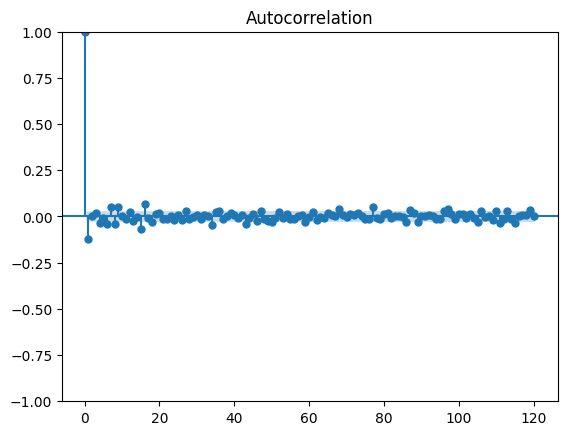

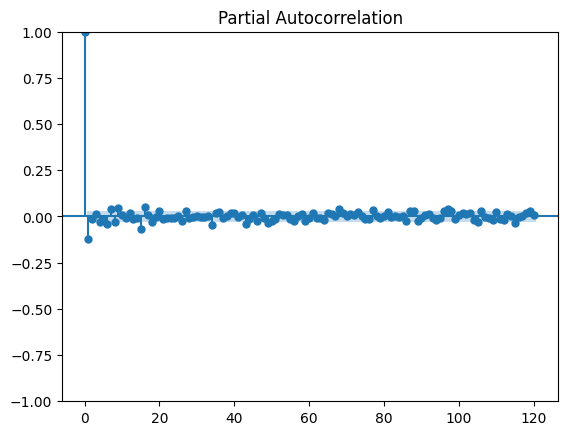

In [28]:
plot_acf(sp500_log_returns.dropna(), lags=120)
plot_pacf(sp500_log_returns.dropna(), lags=120)
plt.show()

In [29]:
# ipotesi nulla test: ASSENZA di autocorrelazione 

results_ljung_box = acorr_ljungbox(sp500_log_returns.dropna(), lags=[10], return_df=True)
print("Risultati Test di Ljung-Box:\n", results_ljung_box)

results_ljung_box = acorr_ljungbox(sp500_log_returns.dropna(), lags=[20], return_df=True)
print("Risultati Test di Ljung-Box:\n", results_ljung_box)

results_ljung_box = acorr_ljungbox(sp500_log_returns.dropna(), lags=[30], return_df=True)
print("Risultati Test di Ljung-Box:\n", results_ljung_box)

results_ljung_box = acorr_ljungbox(sp500_log_returns.dropna(), lags=[60], return_df=True)
print("Risultati Test di Ljung-Box:\n", results_ljung_box)

results_ljung_box = acorr_ljungbox(sp500_log_returns.dropna(), lags=[120], return_df=True)
print("Risultati Test di Ljung-Box:\n", results_ljung_box)

Risultati Test di Ljung-Box:
        lb_stat     lb_pvalue
10  125.118961  4.612446e-22
Risultati Test di Ljung-Box:
       lb_stat     lb_pvalue
20  187.66803  3.041906e-29
Risultati Test di Ljung-Box:
        lb_stat     lb_pvalue
30  198.441492  9.688281e-27
Risultati Test di Ljung-Box:
        lb_stat     lb_pvalue
60  259.104978  1.443101e-26
Risultati Test di Ljung-Box:
         lb_stat     lb_pvalue
120  375.486545  4.214421e-28


#### <span style="color: #99CC99; font-weight: bold;">ipotesi nulla Test di Ljung-Box: NON ESISTE AUTOCORRELAZIONE</span>


nota: il Test di Ljung-Box misura l autocorrelazione e non l autocorrelazione parziale quindi vuol dire che se si registra già un autocorrelazione significativa nei primi lag il test potrebbe accettare l ipotesi nulla anche per lag successivi anche se di fatto autocorrelazione non c'è.
quello che bisogna guardare allora è come cresce la statistica all aumentare dei lag: se la crescita è lineare allora vuol dire che c'è autocorrelazione significativa anche a lag superiori altrimenti se la statistica aumenta di poco all aumentare dei lag vuol dire che l autocorrelazione può non essere significativa.
inoltre è utile osservare come cambia il p-value all'aumentare del numero di lag considerati. Se il p-value rimane basso o diminuisce ulteriormente con l'aumentare dei lag, ciò suggerisce che l'autocorrelazione è presente a lag superiori.

Essendo che si è riscontrata autocorrelazione nei rendimenti ha senso applicare un modello di serie temporali per adattarlo ai dati

#### <span style="color: #99CC99; font-weight: bold;">TEST ARCH Lagrange Multiplier (LM test) </span>


* lm_test[0]: Statistiche del test LM:

Questo valore rappresenta la statistica del test LM calcolata per verificare la presenza di effetti ARCH nella serie temporale.
È basata sull'approccio Lagrange Multiplier (LM) e serve per determinare se i residui della serie temporale mostrano un pattern di varianza autoregressiva.

* lm_test[1]: P-value:

Questo è il p-value associato alla statistica LM. Il p-value indica la probabilità che l'ipotesi nulla (che non ci sia effetto ARCH) sia vera.
Un p-value basso (solitamente inferiore a 0.05) suggerisce che si può rifiutare l'ipotesi nulla e quindi concludere che esiste un effetto ARCH significativo nella serie temporale.

* lm_test[2]: F-statistic:

Questo valore rappresenta la statistica F del test. La statistica F è un altro metodo per verificare la presenza di effetti ARCH, confrontando la varianza spiegata con la varianza residua.
È un indicatore alternativo della presenza di eteroschedasticità nella serie temporale.
* lm_test[3]: F-test P-value:

Questo è il p-value associato alla statistica F. Analogamente al p-value del test LM, un p-value basso qui suggerisce che si può rifiutare l'ipotesi nulla di nessun effetto ARCH, indicando che c'è una varianza condizionale variabile nel tempo.

#### <span style="color: #99CC99; font-weight: bold;">CROSS VALIDAZIONE SUL DATASET </span>

In [30]:
#alleno i modelli garch solo su un numero limitato di osservazioni passate definite dal parametro 'period'
percentage_absolute_error_list, percentage_error_list = garch_models_cross_validation(sp500_high_log_returns, '2019-01-02', '2024-08-20', 252)

Iterazione: 3522
Iterazione: 3523
Iterazione: 3524
Iterazione: 3525
Iterazione: 3526
Iterazione: 3527
Iterazione: 3528
Iterazione: 3529
Iterazione: 3530
Iterazione: 3531
Iterazione: 3532
Iterazione: 3533
Iterazione: 3534
Iterazione: 3535
Iterazione: 3536
Iterazione: 3537
Iterazione: 3538
Iterazione: 3539
Iterazione: 3540
Iterazione: 3541
Iterazione: 3542
Iterazione: 3543
Iterazione: 3544
Iterazione: 3545
Iterazione: 3546
Iterazione: 3547
Iterazione: 3548
Iterazione: 3549
Iterazione: 3550
Iterazione: 3551
Iterazione: 3552
Iterazione: 3553
Iterazione: 3554
Iterazione: 3555
Iterazione: 3556
Iterazione: 3557
Iterazione: 3558
Iterazione: 3559
Iterazione: 3560
Iterazione: 3561
Iterazione: 3562
Iterazione: 3563
Iterazione: 3564
Iterazione: 3565
Iterazione: 3566
Iterazione: 3567
Iterazione: 3568
Iterazione: 3569
Iterazione: 3570
Iterazione: 3571
Iterazione: 3572
Iterazione: 3573
Iterazione: 3574
Iterazione: 3575
Iterazione: 3576
Iterazione: 3577
Iterazione: 3578
Iterazione: 3579
Iterazione: 35

In [31]:
percentage_absolute_error = [tup[0] for tup in percentage_absolute_error_list]
percentage_error = [tup[0] for tup in percentage_error_list]

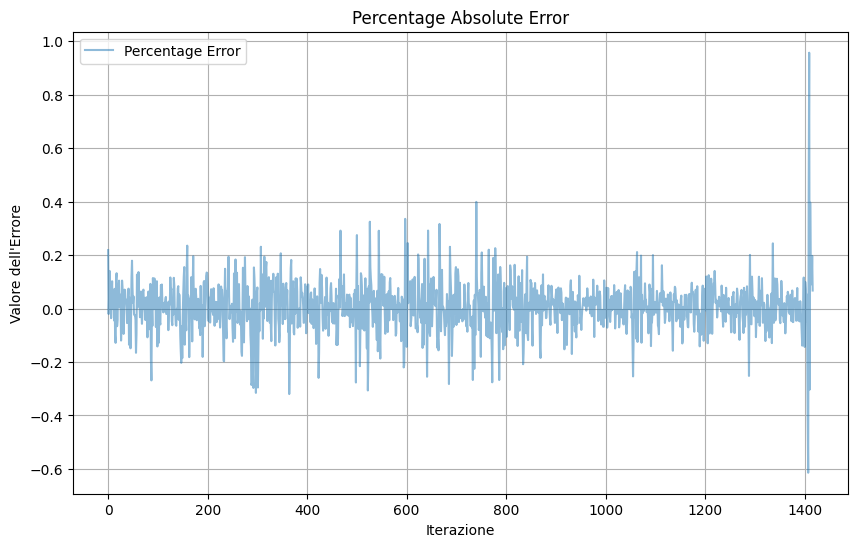

In [39]:
# Crea un range per l'asse x basato sulla lunghezza delle liste
x = range(len(percentage_error))

# Crea il grafico
plt.figure(figsize=(10, 6))
plt.plot(x, percentage_error, label='Percentage Error', alpha=0.5)

# Aggiungi titolo e etichette agli assi
plt.title('Percentage Absolute Error')
plt.xlabel('Iterazione')
plt.ylabel('Valore dell\'Errore')

# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.grid(True)
plt.show()

C:\Users\riky_\AppData\Local\Temp\ipykernel_17428\3001326600.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([percentage_absolute_error], labels=['Percentage Absolute Error'])


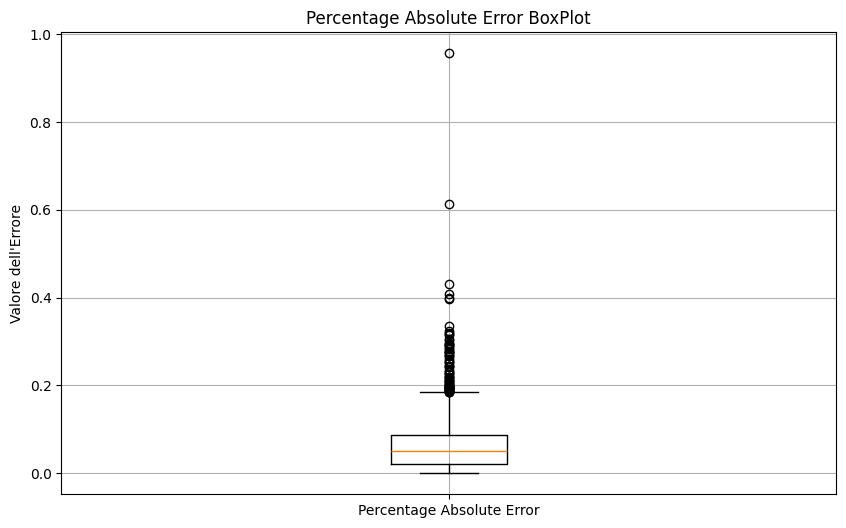

In [33]:
plt.figure(figsize=(10, 6))
plt.boxplot([percentage_absolute_error], labels=['Percentage Absolute Error'])

# Aggiungi titolo e etichette agli assi
plt.title('Percentage Absolute Error BoxPlot')
plt.ylabel('Valore dell\'Errore')

# Mostra il grafico
plt.grid(True)
plt.show()


In [40]:
percentage_error_results_ljung_box = acorr_ljungbox(percentage_error, lags=[20], return_df=True)
print("Risultati Test di Ljung-Box:\n", percentage_error_results_ljung_box)

Risultati Test di Ljung-Box:
        lb_stat     lb_pvalue
20  127.827425  9.951325e-18


In [35]:
lm_arch_test(pd.Series(percentage_error))

Statistiche del test LM: 326.38387843494826
P-value: 4.054476895251609e-64
F-statistic: 42.16408447019077
F-test P-value: 2.9161596203495724e-73


(326.38387843494826,
 4.054476895251609e-64,
 42.16408447019077,
 2.9161596203495724e-73)

#### <span style="color: #99CC99; font-weight: bold;">CONCLUSIONE </span>

Osservando i residui al quadrato di un modello garch quando vengono usati meno dati per la stima dei suoi parametri si può notare come essi presentano due caratteristiche:

* siano correlati -> il modello non riesce quindi a catturare le dinamiche sottostanti catturando tutta lautocorrelazione dei dati
* siano presenti effetti arch -> il fenomeno della volatilità eteroschedastica (volatilità cluster) non sembra ben catturato dal modello.

Osservazioni finale: il forecasting degli indici azionari è un attività molto complessa data la natura della serie temporale analizzata, non si riescono a catturare a pieno gli effetti di volatilità eteroschedastica in quanto il mercato azionario è soggetto a cambiamenti che nel tempo ne modificano le caratteristiche. Inoltre è stato dimostrato che gli indici azionari sono generati da diversi regimi, di conseguenza gli strumenti più opportuni per il loro studio sarebbero i Markow Switching Models che verranno analizzati nel prossimo progetto.

In [41]:
print(f"Mean Percentage Absolute Error: {np.mean(percentage_absolute_error)}")

print(f"Mean Percentage Error: {np.mean(percentage_error)}")


Mean Percentage Absolute Error: 0.06553887046879485
Mean Percentage Error: 0.005028473016383888


In [42]:
# Convert to DataFrame
df = pd.DataFrame(vix_forecast_list, columns=['VIX Forecast', 'Date'])
df.set_index(df['Date'].dt.strftime('%Y.%m.%d'), inplace=True)
df.drop(columns=['Date'], inplace=True)

#import ace_tools as tools; tools.display_dataframe_to_user(name="VIX Forecast DataFrame", dataframe=df)

In [ ]:
df.to_csv("VIX_FORECAST_CLOSE.csv", index=True)